## Logistic Regression
Logistic Regression is Classification algorithm commonly used in Machine Learning. It allows categorizing data into discrete classes by learning the relationship from a given set of labeled data. It learns a linear relationship from the given dataset and then introduces a non-linearity in the form of the Sigmoid function.

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
  
def sigmoid(z): 
    return 1 / (1 + np.exp( - z)) 
  
plt.plot(np.arange(-5, 5, 0.1), sigmoid(np.arange(-5, 5, 0.1))) 
plt.title('Visualization of the Sigmoid Function') 
  
plt.show() 

## Load dataset

The iris flower dataset is available on Keras dataset API(https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html) The following code loads the Iris dataset to your machine:

In [ ]:
from sklearn import datasets

# import iris data from sklearn datasets library
iris = datasets.load_iris()

In [ ]:
import pandas as pd
import tensorflow as tf
# To use tenforflow 1.x functions, import compact v1
# import tensorflow.compat.v1 as tf
# tf.enable_eager_execution()
# # # make unable to use tensorflow v2.x functions to avoid crash
# tf.disable_v2_behavior()

# change to pandas dataframe
iris = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
iris = iris.astype({"target": int })

print(iris)
print(iris.shape)

In [1]:
import json
import os
import sys

output_directory = "libraries/"
output_filename = "iris.json"
full_path = os.path.join(output_directory, output_filename)

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import libraries.vector as vector

cm = vector.Visualization(full_path)
cm.display()

## Explore the data 

Let's take a moment to understand the format of the data. Each data contains sepal length, sepal width, petal length, petal width and a corresponding species label. The label is an integer value of either 0 or 1, where 0 is a 'Iris-setosa', and 1 is a 'Iris-versicolo'.

In [ ]:
#Let's check head of dataframe
iris.head()

In [ ]:
#Let's make a scatter plot with sepal length and width between two iris species in the dataframe
import matplotlib.pyplot as plt

plt.scatter(iris['sepal length (cm)'][:50], iris['sepal width (cm)'][:50], label='Iris-setosa')
plt.scatter(iris['sepal length (cm)'][51:], iris['sepal width (cm)'][51:], label='Iris-versicolo')
plt.scatter(iris['sepal length (cm)'][101:], iris['sepal width (cm)'][101:], label='Iris-virginica')
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.legend(loc='best')

## Pre-Processing Data

Create x value as the features and y value as species (labels) from the dataframe

In [ ]:
x = iris.drop(labels=['target'], axis=1).values
y = iris['target'].values

Set a seed to get reproducibility for numpy and tensorflow

In [ ]:
seed = 23
np.random.seed(seed)
tf.random.set_seed(seed)

Next, split the dataset into trainset (60%) and testset (40%) 

In [ ]:
# use random choice from numpy library to set dataset randomly
train_data = np.random.choice(len(x), round(len(x) * 0.6), replace=False)
test_data = np.array(list(set(range(len(x))) - set(train_data)))

# separate the dataset into features and labels
x_train = x[train_data]
y_train = y[train_data]
x_test = x[test_data]
y_test = y[test_data]

# the number of labels
num_labels = 3 

# the number of features: sepal length & width, petal length & width
num_features = 4

# Convert to float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])


Now, we need to normalize the feature values in the dataset.
Normalization is optional for logistic regression. However, the main goal of normalizing features is to help convergence of the technique used for optimization.

In [ ]:
# Define the normalization function
def min_max_normalization(data):
    col_max = np.max(data, axis=0)
    col_min = np.min(data, axis=0)
    return np.divide(data - col_min, col_max - col_min)

In [ ]:
# Normalized processing, must be placed after the data set segmentation, 
# otherwise the test set will be affected by the training set
x_train = min_max_normalization(x_train)
x_test = min_max_normalization(x_test)

## Build the model
With the pre-processed dataset, we start to build the model with tensorflow

In [ ]:
# Begin building the model framework
# Declare the variables that need to be learned and initialization
# Weight of shape [4, 3]

W = tf.Variable(tf.ones([num_features, num_labels]), name="weight")

# Bias of shape [3], the total number of classes.

b = tf.Variable(tf.zeros([num_labels]), name="bias")

#W = tf.Variable(tf.random.normal([2, 1], mean=0.0))
#b = tf.Variable(tf.random.normal([1], mean=0.0))
# The tf 2.x doesn't need to use tf.global_variables_initializer() and place holders
#init = tf.global_variables_initializer()
#sess = tf.Session()
#sess.run(init)


Define the logistic regression to learn about variables

In [ ]:
# Logistic regression (Wx + b).

def logistic_regression(x):

    # Apply softmax to normalize the logits to a probability distribution.

    return tf.nn.softmax(tf.matmul(x, W) + b)

### Loss function and optimizer

Let's declare the loss function

The loss function is critical for machine & deep learning models.
The loss function for linear regression is squared loss, but the loss function for logistic regression is Log Loss, which is defined as follows:

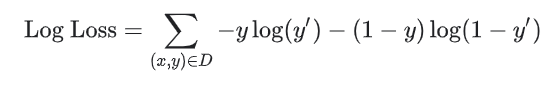

where:

* (x,y) ∈ D is the data set containing many labeled examples, which are  (x,y) pairs.
* y is the label in a labeled example. Since this is logistic regression, every value of y must either be 0 or 1.
* y' is the predicted value (somewhere between 0 and 1), given the set of features in x.


In [ ]:
# Cross-Entropy loss function.

def cross_entropy(y_pred, y_true):

    # Encode label to a one hot vector.

    y_true = tf.one_hot(y_true, depth=num_labels)

    # Clip prediction values to avoid log(0) error.

    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Compute cross-entropy.

    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))


Before train our model, we need to set the parameters: learning rate, batch size, and the number of epoch interations.


* Learning rate is a hyper-parameter that controls how much we are adjusting the weights of our network with respect the loss gradient.

* Batch size defines the number of samples that will be propagated through the network.

* An epoch is a full iteration over samples during model training.

In [ ]:
learning_rate = 0.003
batch_size = 32
epoch_iteration_num = 2000
display_step = 100

Now we need to define optimizer to find optimized parameters.

In [ ]:
# Accuracy metric.

def accuracy(y_pred, y_true):

# Predicted class is the index of the highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))

    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Stochastic gradient descent optimizer.

optimizer = tf.optimizers.SGD(learning_rate)

## Train the model

In [ ]:
# Use tf.data API to shuffle and batch data.

train_data=tf.data.Dataset.from_tensor_slices((x_train,y_train))

train_data=train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

# create variables to store result
losses = []
train_accs = []
test_accs = []

# Optimization process. 

def run_optimization(x, y):

# Wrap computation inside a GradientTape for automatic differentiation.

    with tf.GradientTape() as g:

        pred = logistic_regression(x)

        loss = cross_entropy(pred, y)
        losses.append(loss)

    # Compute gradients.

    gradients = g.gradient(loss, [W, b])

  

    # Update W and b following gradients.

    optimizer.apply_gradients(zip(gradients, [W, b]))

In [ ]:
# Run training for the given number of steps.

for epoch, (batch_x, batch_y) in enumerate(train_data.take(epoch_iteration_num), 1):

    # Run the optimization to update W and b values.

    run_optimization(batch_x, batch_y)
    train_pred = logistic_regression(batch_x)
    train_acc = accuracy(train_pred, batch_y)
    test_pred = logistic_regression(x_test)
    test_acc = accuracy(test_pred, y_test)
    # recode the result
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    

    if epoch % display_step == 0:

        #pred = logistic_regression(batch_x)

        loss = cross_entropy(train_pred, batch_y)


        #print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))
        print('epoch: {:4d} loss: {:5f} train accuracy: {:5f} test accuracy: {:5f}'.format(epoch, loss,
                                                                          train_acc, test_acc))

Let's make plot of the loss per epoch from the model training

In [ ]:
plt.plot(losses)
plt.title('Cross Entropy Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
plt.plot(train_accs, 'b-', label='train accuracy')
plt.plot(test_accs, 'r-', label='test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Train and Test Accuracy')
plt.legend(loc='best')
plt.show()

In [ ]:
# Test model on validation set.
model_prediction = []
testing_predictions = ((logistic_regression(x_test) > 0.5).numpy()).astype("int32")

for i in range(len(testing_predictions)):
    for j in range(len(testing_predictions[i])):
        if testing_predictions[i][j] == 1:
            model_prediction.append(j)

pred = logistic_regression(x_test)
probas = pred.numpy()
np.set_printoptions(precision=5, suppress=True)

print("Test Accuracy: %f" % accuracy(pred, y_test))


In [ ]:
import json
import os
import sys

output_directory = "libraries/"
output_filename = "predict_LR.json"
full_path = os.path.join(output_directory, output_filename)

data = []
data.extend([{
      'index': i,
      'true_label': int(y_test[i]),
      'predicted_label': model_prediction[i],
      'confidence_score': probas.tolist()[i],
      'text': str(x_test.tolist()[i])
  } for i in range(len(testing_predictions))])


with open(full_path, 'w') as outfile:
    json.dump(data, outfile, indent=8, sort_keys=False)

--------------------------------------------------easy way (don't run yet) -------------------------------------------------------------

In [ ]:
# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0, solver='lbfgs', multi_class='auto')
classifier.fit(x_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(x_test)
# Predict probabilities
probs_y=classifier.predict_proba(x_test)
### Print results 
probs_y = np.round(probs_y, 2)
res = "{:<10} | {:<10} | {:<10} | {:<13} | {:<5}".format("y_test", "y_pred", "Setosa(%)", "versicolor(%)", "virginica(%)\n")
res += "-"*65+"\n"
res += "\n".join("{:<10} | {:<10} | {:<10} | {:<13} | {:<10}".format(x, y, a, b, c) for x, y, a, b, c in zip(y_test, y_pred, probs_y[:,0], probs_y[:,1], probs_y[:,2]))
res += "\n"+"-"*65+"\n"
print(res)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
import seaborn as sns
# confusion matrix sns heatmap 
ax = plt.axes()
df_cm = cm
sns.heatmap(df_cm, annot=True, annot_kws={"size": 30}, fmt='d',cmap="Blues", ax = ax )
ax.set_title('Confusion Matrix')
plt.show()